In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit, Poisson
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print("=" * 70)
print("ECON 5140 - HOMEWORK 1")
print("Part A: Generalized Linear Models")
print("Part B: Time Series Decomposition")
print("=" * 70)

ECON 5140 - HOMEWORK 1
Part A: Generalized Linear Models
Part B: Time Series Decomposition


In [2]:
# ====================================================================
# DATASET 1: CUSTOMER PURCHASE DATA (for GLM analysis)
# ====================================================================

print("\n" + "=" * 70)
print("DATASET 1: Customer Purchase Behavior")
print("=" * 70)
n_customers = 1000
# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers) # in thousands
time_on_site = np.random.gamma(2, 3, n_customers) # in minutes
# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)
# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)
# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})
print(f"Number of customers: {len(df_customers)}")
print(f"Purchase rate: {df_customers['Purchase'].mean():.2%}")
print(f"\nFirst 5 rows:")
print(df_customers.head())


DATASET 1: Customer Purchase Behavior
Number of customers: 1000
Purchase rate: 90.00%

First 5 rows:
         Age     Income  TimeOnSite  Purchase
0  39.967142  70.990332    2.814421         1
1  33.617357  63.869505    4.460907         1
2  41.476885  50.894456    0.667441         1
3  50.230299  40.295948    5.872412         1
4  32.658466  60.473350    8.012511         1


In [4]:
# ====================================================================
# DATASET 2: E-COMMERCE SALES TIME SERIES
# ====================================================================

print("\n" + "=" * 70)
print("DATASET 2: E-commerce Daily Sales")
print("=" * 70)
# Create 2 years of daily data
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)
# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)
# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date)
    special_events[bf_idx] = 800
    
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400
# Random noise
noise = np.random.normal(0, 50, n_days)
# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)
# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)
print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of days: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())


DATASET 2: E-commerce Daily Sales
Date range: 2024-01-01 to 2025-12-31
Number of days: 731

Sales Statistics:
count     731.000000
mean     3515.098101
std      1973.038173
min      1061.388824
25%      1587.211754
50%      3304.552751
75%      4954.843016
max      8308.867019
Name: Sales, dtype: float64



PART A: GENERALIZED LINEAR MODELS

----------------------------------------------------------------------
A1: Exploratory Data Analysis
----------------------------------------------------------------------
✓ Box plots saved as 'a1_boxplots.png'

Comparison of Means:
--------------------------------------------------
Age          - Non-Purchasers:  28.67 | Purchasers:  35.92
Income       - Non-Purchasers:  40.15 | Purchasers:  52.27
TimeOnSite   - Non-Purchasers:   3.93 | Purchasers:   6.34
✓ Correlation heatmap saved as 'a1_correlation.png'


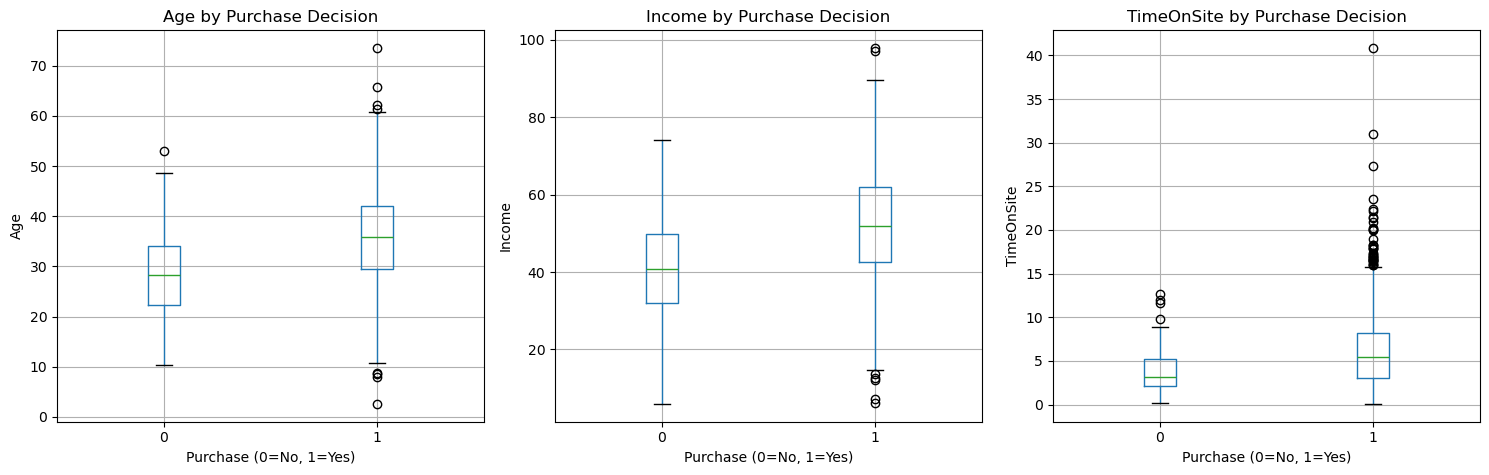

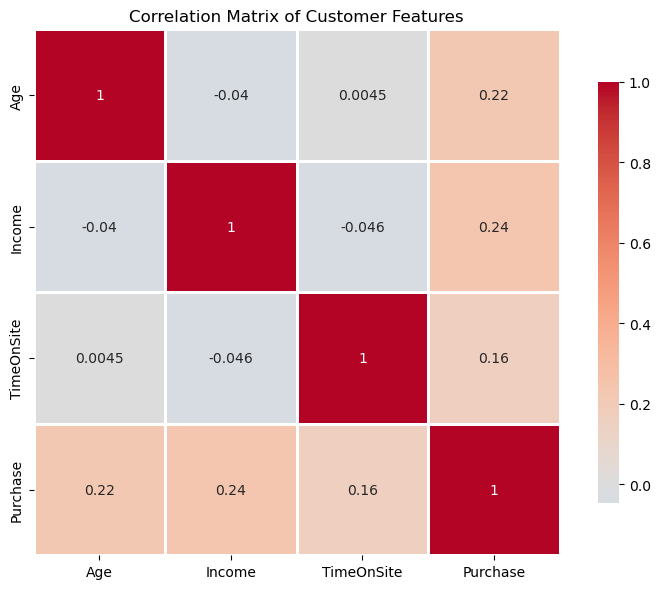

In [5]:
# ====================================================================
# PART A: GENERALIZED LINEAR MODELS
# ====================================================================


print("\n" + "=" * 70)
print("PART A: GENERALIZED LINEAR MODELS")
print("=" * 70)

# --------------------------------------------------------------------
# A1: Exploratory Data Analysis (GLM)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A1: Exploratory Data Analysis")
print("-" * 70)

# 1. Box plots comparing features between purchasers and non-purchasers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['Age', 'Income', 'TimeOnSite']
for i, feature in enumerate(features):
    df_customers.boxplot(column=feature, by='Purchase', ax=axes[i])
    axes[i].set_title(f'{feature} by Purchase Decision')
    axes[i].set_xlabel('Purchase (0=No, 1=Yes)')
    axes[i].set_ylabel(feature)
plt.suptitle('')
plt.tight_layout()
plt.savefig('a1_boxplots.png', dpi=300, bbox_inches='tight')
print("✓ Box plots saved as 'a1_boxplots.png'")

# 2. Calculate mean values for each group
print("\nComparison of Means:")
print("-" * 50)
for feature in features:
    mean_no = df_customers[df_customers['Purchase']==0][feature].mean()
    mean_yes = df_customers[df_customers['Purchase']==1][feature].mean()
    print(f"{feature:12} - Non-Purchasers: {mean_no:6.2f} | Purchasers: {mean_yes:6.2f}")

# 3. Correlation matrix heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_customers.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Customer Features')
plt.tight_layout()
plt.savefig('a1_correlation.png', dpi=300, bbox_inches='tight')
print("✓ Correlation heatmap saved as 'a1_correlation.png'")


----------------------------------------------------------------------
A2: Linear Probability Model
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        01:27:44   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

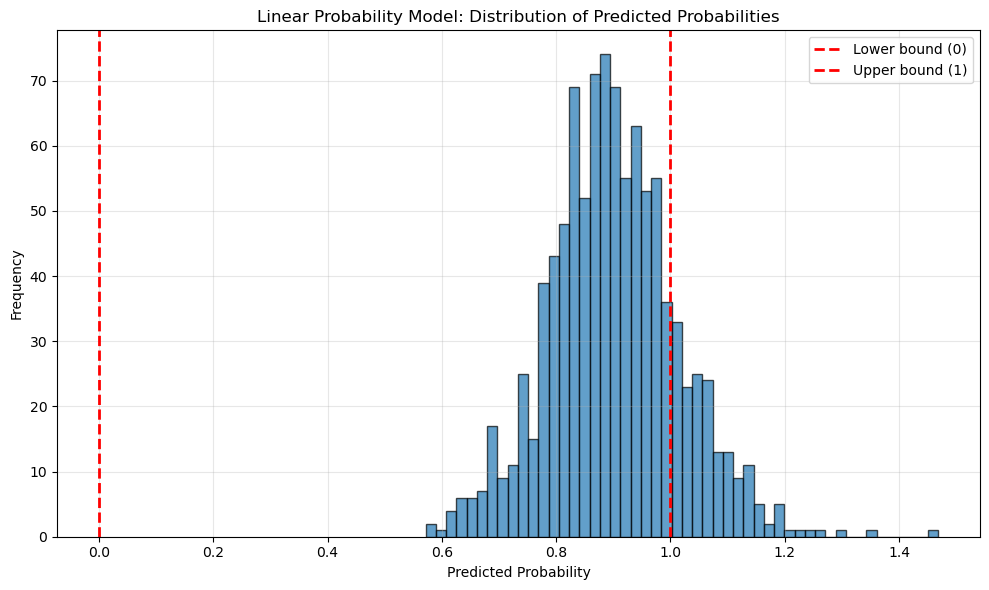

In [6]:
# --------------------------------------------------------------------
# A2: Linear Probability Model (LPM)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A2: Linear Probability Model")
print("-" * 70)

# 1. Fit OLS model
X = df_customers[['Age', 'Income', 'TimeOnSite']]
X = sm.add_constant(X)
y = df_customers['Purchase']
lpm_model = sm.OLS(y, X).fit()

# 2. Print regression summary
print(lpm_model.summary())

# 3. Calculate predicted probabilities and check validity
lpm_predictions = lpm_model.predict(X)
invalid_predictions = ((lpm_predictions < 0) | (lpm_predictions > 1)).sum()
pct_invalid = 100 * invalid_predictions / len(lpm_predictions)
print(f"\n⚠ Invalid predictions (outside [0,1]): {invalid_predictions} ({pct_invalid:.2f}%)")

# 4. Histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(lpm_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Lower bound (0)')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Upper bound (1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Linear Probability Model: Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('a2_lpm_predictions.png', dpi=300, bbox_inches='tight')
print("✓ LPM predictions histogram saved as 'a2_lpm_predictions.png'")


----------------------------------------------------------------------
A3: Logistic Regression
----------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.238157
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        01:30:47   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------

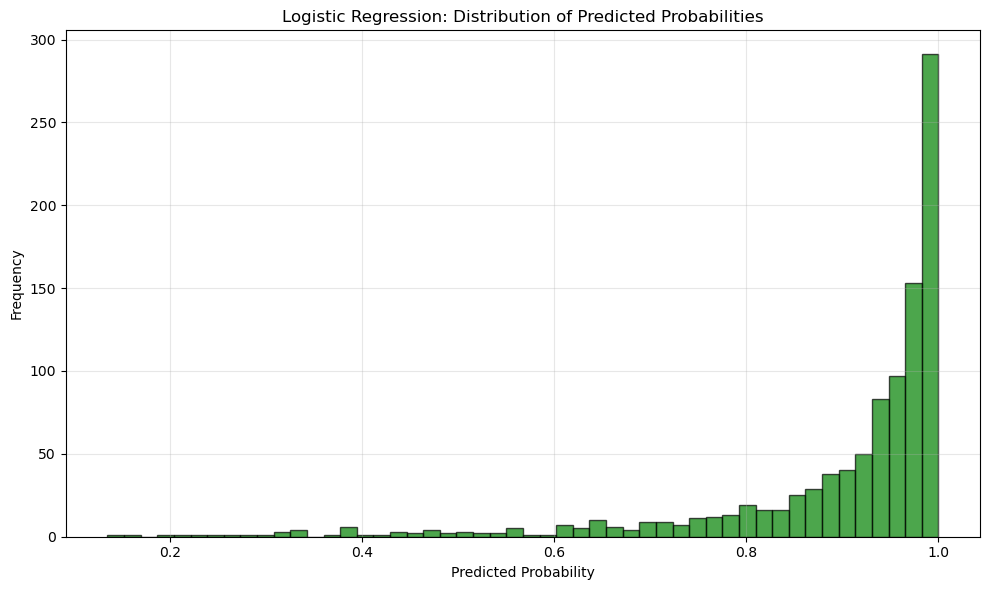

In [7]:
# --------------------------------------------------------------------
# A3: Logistic Regression
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A3: Logistic Regression")
print("-" * 70)

# 1. Fit logistic regression
logit_model = sm.Logit(y, X).fit()

# 2. Print summary and extract key statistics
print(logit_model.summary())

coefficients = logit_model.params
odds_ratios = np.exp(coefficients)
p_values = logit_model.pvalues

print("\n" + "=" * 60)
print("Coefficient Interpretation")
print("=" * 60)
for var in ['Age', 'Income', 'TimeOnSite']:
    coef = coefficients[var]
    or_val = odds_ratios[var]
    p_val = p_values[var]
    print(f"\n{var}:")
    print(f"  Coefficient (β): {coef:.6f}")
    print(f"  Odds Ratio: {or_val:.6f}")
    print(f"  p-value: {p_val:.6f}")
    print(f"  Interpretation: A 1-unit increase in {var} changes the log-odds")
    print(f"                  of purchase by {coef:.6f}, or multiplies the odds by {or_val:.4f}")

# 3. Calculate predicted probabilities
logit_predictions = logit_model.predict(X)
print(f"\n✓ All logistic predictions are in [0,1]: {((logit_predictions >= 0) & (logit_predictions <= 1)).all()}")

# 4. Histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(logit_predictions, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Logistic Regression: Distribution of Predicted Probabilities')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('a3_logit_predictions.png', dpi=300, bbox_inches='tight')
print("✓ Logistic predictions histogram saved as 'a3_logit_predictions.png'")

In [8]:
# --------------------------------------------------------------------
# A4: Prediction for New Customers
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A4: Predictions for New Customers")
print("-" * 70)

# New customers
new_customers = pd.DataFrame({
    'Age': [25, 35, 45, 55],
    'Income': [30, 50, 70, 90],
    'TimeOnSite': [2, 5, 8, 10]
})

# 1. Predict purchase probability
new_customers_X = sm.add_constant(new_customers)
new_predictions = logit_model.predict(new_customers_X)

# 2. Create formatted table
new_customers['Predicted_Probability'] = new_predictions
new_customers['Classification'] = (new_predictions > 0.5).astype(int)
new_customers['Decision'] = new_customers['Classification'].map({0: 'No Purchase', 1: 'Purchase'})

print("\nPredictions for New Customers:")
print("=" * 80)
print(new_customers.to_string(index=False))

# 3. Identify most likely purchaser
max_prob_idx = new_predictions.argmax()
print("\n" + "=" * 80)
print(f"Most Likely to Purchase: Customer {max_prob_idx + 1}")
print(f"  Age: {new_customers.iloc[max_prob_idx]['Age']}")
print(f"  Income: ${new_customers.iloc[max_prob_idx]['Income']}k")
print(f"  Time on Site: {new_customers.iloc[max_prob_idx]['TimeOnSite']} minutes")
print(f"  Predicted Probability: {new_predictions[max_prob_idx]:.4f}")
print("\nWhy? This customer has the highest income ($90k) and longest time on site")
print("(10 minutes), both strong positive predictors of purchase behavior.")


----------------------------------------------------------------------
A4: Predictions for New Customers
----------------------------------------------------------------------

Predictions for New Customers:
 Age  Income  TimeOnSite  Predicted_Probability  Classification    Decision
  25      30           2               0.371500               0 No Purchase
  35      50           5               0.942887               1    Purchase
  45      70           8               0.997836               1    Purchase
  55      90          10               0.999898               1    Purchase

Most Likely to Purchase: Customer 4
  Age: 55
  Income: $90k
  Time on Site: 10 minutes
  Predicted Probability: 0.9999

Why? This customer has the highest income ($90k) and longest time on site
(10 minutes), both strong positive predictors of purchase behavior.



PART B: TIME SERIES ANALYSIS

----------------------------------------------------------------------
B1: Time Series Visualization
----------------------------------------------------------------------
✓ Time series plot saved as 'b1_timeseries.png'
✓ Seasonal plots saved as 'b1_seasonal.png'

Mean Sales by Day of Week:
--------------------------------------------------
Monday    : $3,522.60
Tuesday   : $3,596.69
Wednesday : $3,621.39
Thursday  : $3,534.35
Friday    : $3,462.56
Saturday  : $3,421.21
Sunday    : $3,445.00

Mean Sales by Month:
--------------------------------------------------
Jan  : $2,327.50
Feb  : $2,540.58
Mar  : $2,743.56
Apr  : $2,898.69
May  : $3,022.61
Jun  : $3,164.05
Jul  : $3,346.56
Aug  : $3,580.81
Sep  : $3,924.31
Oct  : $4,344.18
Nov  : $4,838.29
Dec  : $5,396.12

📊 Key Patterns Observed:
  • Strong upward trend over the 2-year period
  • Weekly seasonality with weekend peaks
  • Yearly seasonality with Q4 peaks (holiday season)
  • Special event spikes v

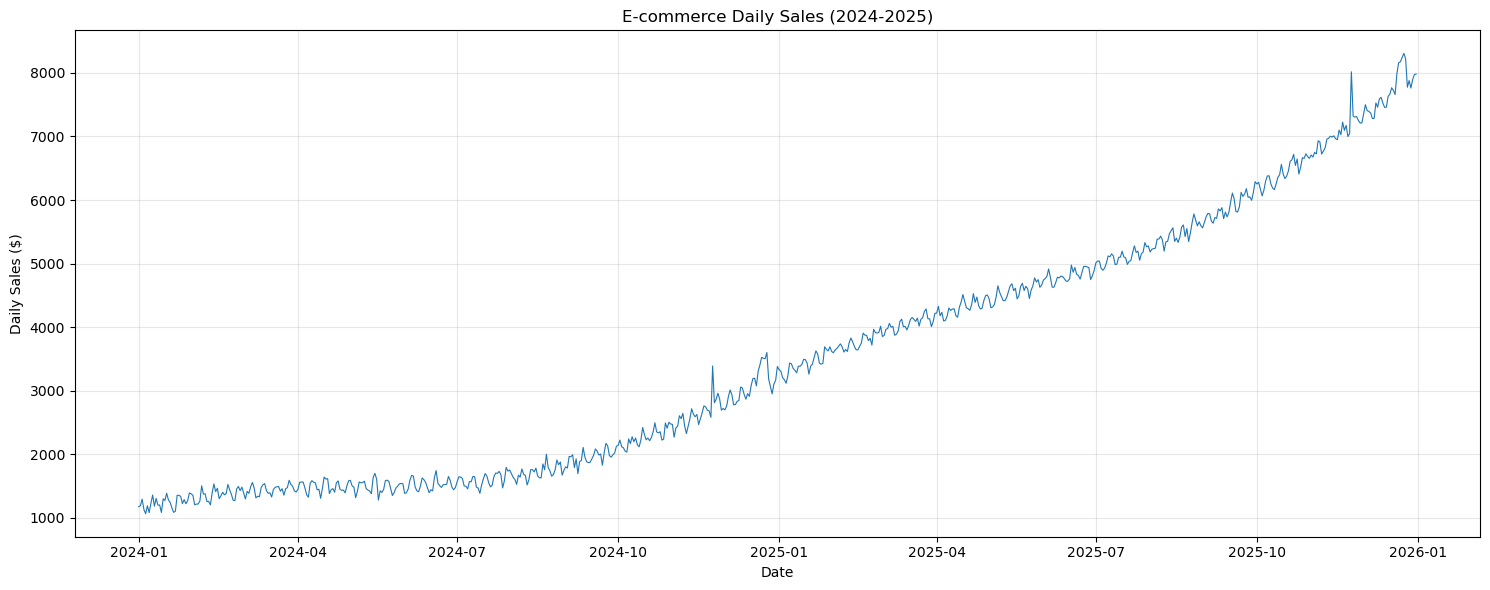

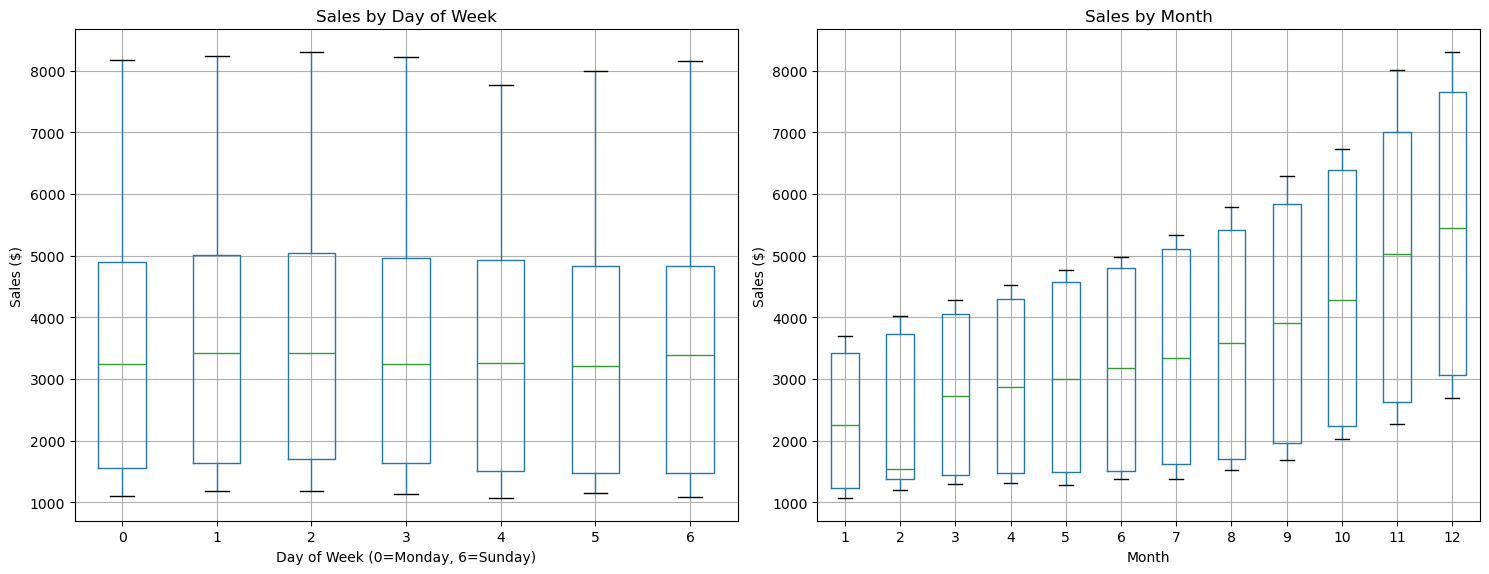

In [9]:
# ====================================================================
# PART B: TIME SERIES ANALYSIS
# ====================================================================
print("\n" + "=" * 70)
print("PART B: TIME SERIES ANALYSIS")
print("=" * 70)

# --------------------------------------------------------------------
# B1: Time Series Visualization
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B1: Time Series Visualization")
print("-" * 70)

# 1. Time series plot of daily sales
plt.figure(figsize=(15, 6))
plt.plot(df_sales.index, df_sales['Sales'], linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Daily Sales ($)')
plt.title('E-commerce Daily Sales (2024-2025)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('b1_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Time series plot saved as 'b1_timeseries.png'")

# 2. Seasonal subseries plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# By day of week
df_sales.boxplot(column='Sales', by='DayOfWeek', ax=axes[0])
axes[0].set_title('Sales by Day of Week')
axes[0].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
axes[0].set_ylabel('Sales ($)')

# By month
df_sales.boxplot(column='Sales', by='Month', ax=axes[1])
axes[1].set_title('Sales by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Sales ($)')

plt.suptitle('')
plt.tight_layout()
plt.savefig('b1_seasonal.png', dpi=300, bbox_inches='tight')
print("✓ Seasonal plots saved as 'b1_seasonal.png'")

# 3. Calculate means
print("\nMean Sales by Day of Week:")
print("-" * 50)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in range(7):
    mean_sales = df_sales[df_sales['DayOfWeek'] == day]['Sales'].mean()
    print(f"{day_names[day]:10}: ${mean_sales:,.2f}")

print("\nMean Sales by Month:")
print("-" * 50)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in range(1, 13):
    mean_sales = df_sales[df_sales['Month'] == month]['Sales'].mean()
    print(f"{month_names[month-1]:5}: ${mean_sales:,.2f}")

# 4. Observations
print("\n📊 Key Patterns Observed:")
print("  • Strong upward trend over the 2-year period")
print("  • Weekly seasonality with weekend peaks")
print("  • Yearly seasonality with Q4 peaks (holiday season)")
print("  • Special event spikes visible (Black Friday, Christmas)")



----------------------------------------------------------------------
B2: Stationarity Check
----------------------------------------------------------------------
✓ Stationarity plots saved as 'b2_stationarity.png'

Stationarity Assessment:
First 6 months - Mean: $1,419.68, Std: $135.04
Last 6 months  - Mean: $6,295.85, Std: $921.57
Mean difference: $4,876.17

⚠ CONCLUSION: The series is NOT stationary
  • Mean increases significantly over time (strong upward trend)
  • Variance appears relatively stable but with seasonal fluctuations
  • Both trend and seasonality present → non-stationary


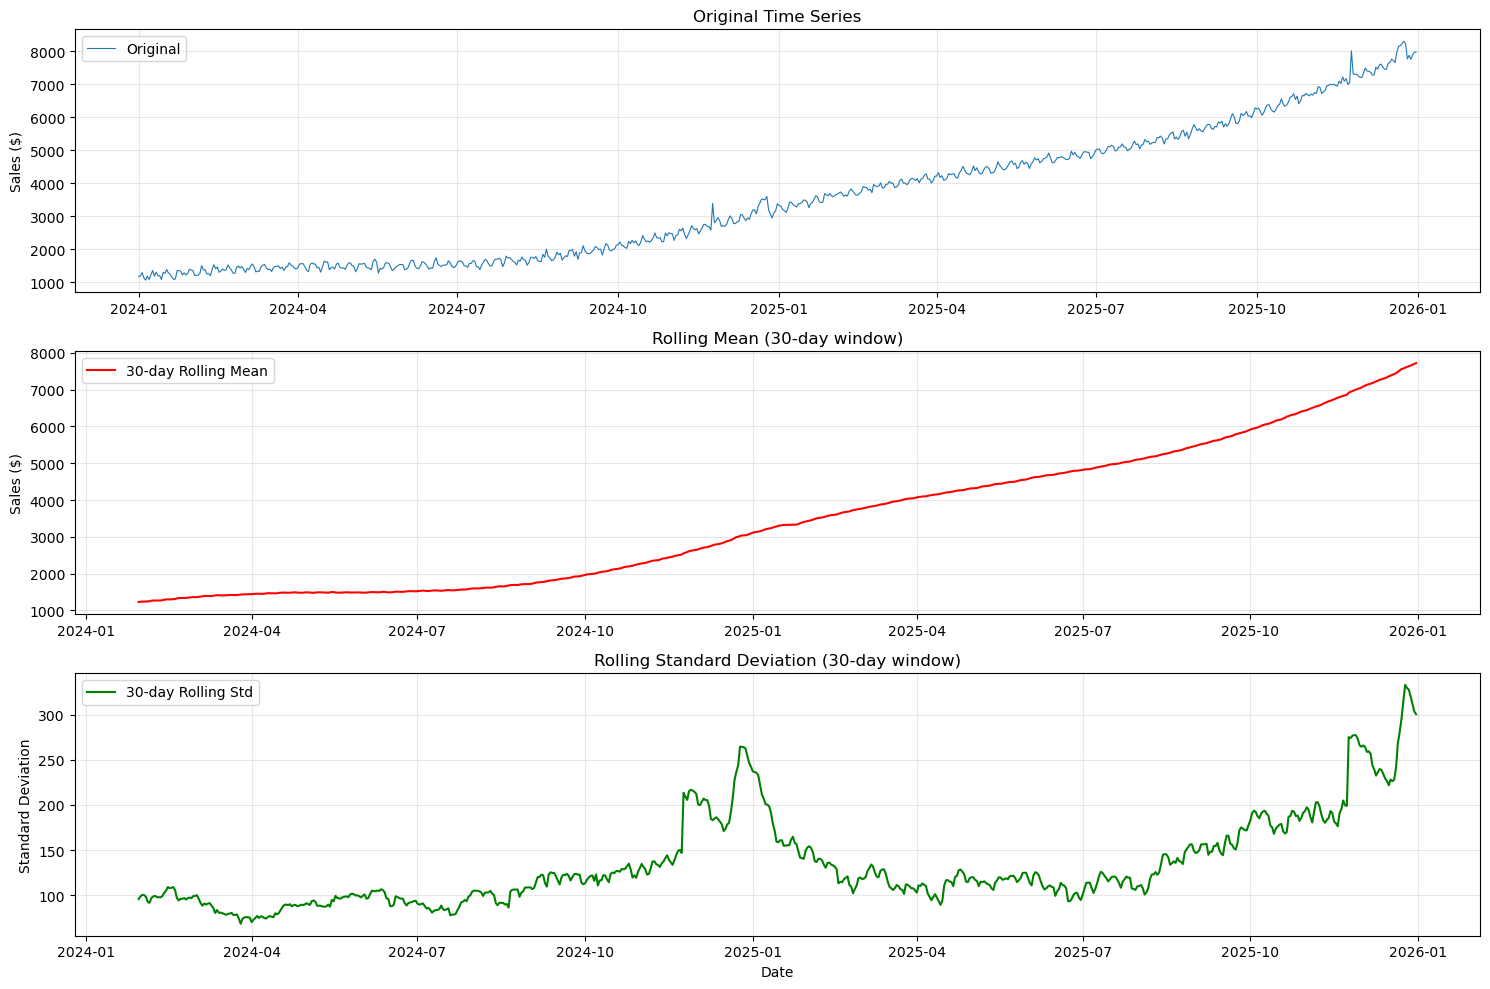

In [10]:
# --------------------------------------------------------------------
# B2: Stationarity Assessment
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B2: Stationarity Check")
print("-" * 70)

# 1. Plot with rolling statistics
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Original series
axes[0].plot(df_sales.index, df_sales['Sales'], label='Original', linewidth=0.8)
axes[0].set_ylabel('Sales ($)')
axes[0].set_title('Original Time Series')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling mean
rolling_mean = df_sales['Sales'].rolling(window=30).mean()
axes[1].plot(df_sales.index, rolling_mean, label='30-day Rolling Mean', color='red', linewidth=1.5)
axes[1].set_ylabel('Sales ($)')
axes[1].set_title('Rolling Mean (30-day window)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Rolling std
rolling_std = df_sales['Sales'].rolling(window=30).std()
axes[2].plot(df_sales.index, rolling_std, label='30-day Rolling Std', color='green', linewidth=1.5)
axes[2].set_ylabel('Standard Deviation')
axes[2].set_xlabel('Date')
axes[2].set_title('Rolling Standard Deviation (30-day window)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('b2_stationarity.png', dpi=300, bbox_inches='tight')
print("✓ Stationarity plots saved as 'b2_stationarity.png'")

# 2. Compare first 6 months vs last 6 months
first_6_months = df_sales['Sales'].iloc[:180]
last_6_months = df_sales['Sales'].iloc[-180:]

print("\nStationarity Assessment:")
print("=" * 60)
print(f"First 6 months - Mean: ${first_6_months.mean():,.2f}, Std: ${first_6_months.std():,.2f}")
print(f"Last 6 months  - Mean: ${last_6_months.mean():,.2f}, Std: ${last_6_months.std():,.2f}")
print(f"Mean difference: ${last_6_months.mean() - first_6_months.mean():,.2f}")

print("\n⚠ CONCLUSION: The series is NOT stationary")
print("  • Mean increases significantly over time (strong upward trend)")
print("  • Variance appears relatively stable but with seasonal fluctuations")
print("  • Both trend and seasonality present → non-stationary")


----------------------------------------------------------------------
B3: Autocorrelation Function
----------------------------------------------------------------------
✓ ACF plot saved as 'b3_acf.png'

Manual Autocorrelation Calculations:
Lag 1 (yesterday):     0.998241
Lag 7 (last week):     0.998086
Lag 30 (last month):   0.995457

📊 Interpretation:
  • Lag 1 ACF = 0.9982: Very strong positive correlation with yesterday
    → High persistence in daily sales
  • Lag 7 ACF = 0.9981: Strong correlation at weekly intervals
    → Clear weekly seasonal pattern
  • Lag 30 ACF = 0.9955: Positive correlation remains high
    → Long-term persistence due to trend component

  • ACF decays very slowly → confirms non-stationarity
  • Sinusoidal pattern in ACF → indicates seasonality


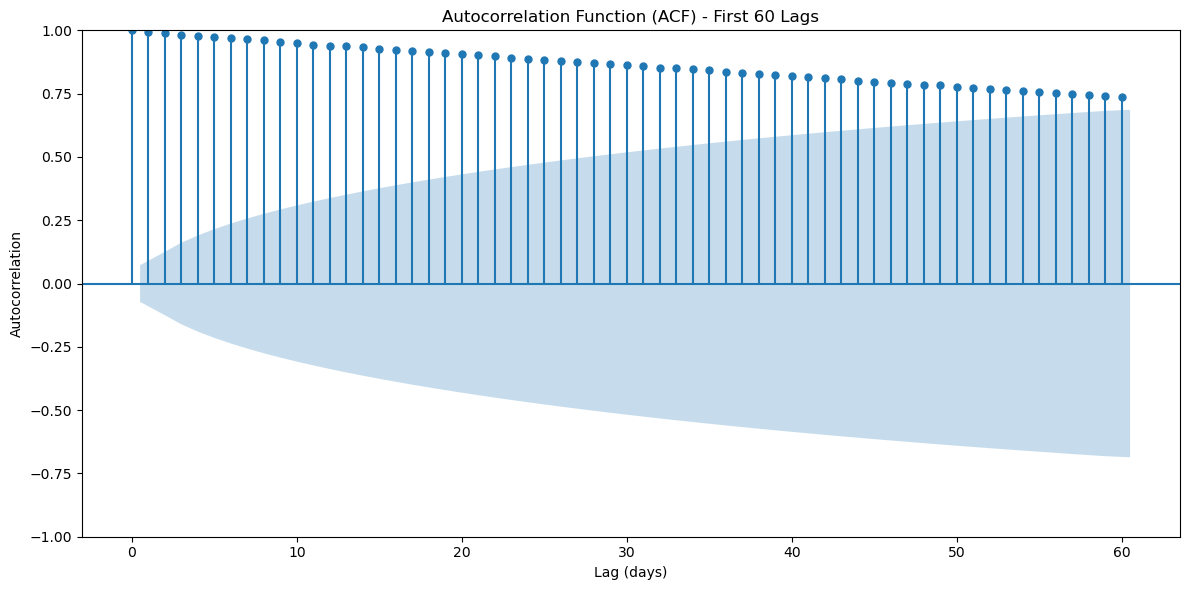

In [11]:
# --------------------------------------------------------------------
# B3: Autocorrelation Analysis
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B3: Autocorrelation Function")
print("-" * 70)

# 1. Plot ACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_sales['Sales'], lags=60, ax=ax)
ax.set_title('Autocorrelation Function (ACF) - First 60 Lags')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
plt.tight_layout()
plt.savefig('b3_acf.png', dpi=300, bbox_inches='tight')
print("✓ ACF plot saved as 'b3_acf.png'")

# 2. Calculate specific autocorrelations manually
sales_array = df_sales['Sales'].values
lag_1_acf = np.corrcoef(sales_array[:-1], sales_array[1:])[0, 1]
lag_7_acf = np.corrcoef(sales_array[:-7], sales_array[7:])[0, 1]
lag_30_acf = np.corrcoef(sales_array[:-30], sales_array[30:])[0, 1]

print("\nManual Autocorrelation Calculations:")
print("=" * 60)
print(f"Lag 1 (yesterday):     {lag_1_acf:.6f}")
print(f"Lag 7 (last week):     {lag_7_acf:.6f}")
print(f"Lag 30 (last month):   {lag_30_acf:.6f}")

# 3. Interpretation
print("\n📊 Interpretation:")
print(f"  • Lag 1 ACF = {lag_1_acf:.4f}: Very strong positive correlation with yesterday")
print("    → High persistence in daily sales")
print(f"  • Lag 7 ACF = {lag_7_acf:.4f}: Strong correlation at weekly intervals")
print("    → Clear weekly seasonal pattern")
print(f"  • Lag 30 ACF = {lag_30_acf:.4f}: Positive correlation remains high")
print("    → Long-term persistence due to trend component")
print("\n  • ACF decays very slowly → confirms non-stationarity")
print("  • Sinusoidal pattern in ACF → indicates seasonality")


----------------------------------------------------------------------
B4: STL Decomposition
----------------------------------------------------------------------
✓ STL decomposition saved as 'b4_stl_decomposition.png'

📊 Component Analysis:

TREND:
  • Starts at: $1,102.77
  • Ends at: $7,971.92
  • Pattern: Strong quadratic upward trend (accelerating growth)

SEASONAL (Weekly):
  • Range: $482.26
  • Pattern: Clear 7-day cycle with weekend peaks

REMAINDER:
  • Std Dev: $76.32
  • Large spikes visible → special events (Black Friday, Christmas)
  • Overall well-behaved random noise after removing trend/seasonal


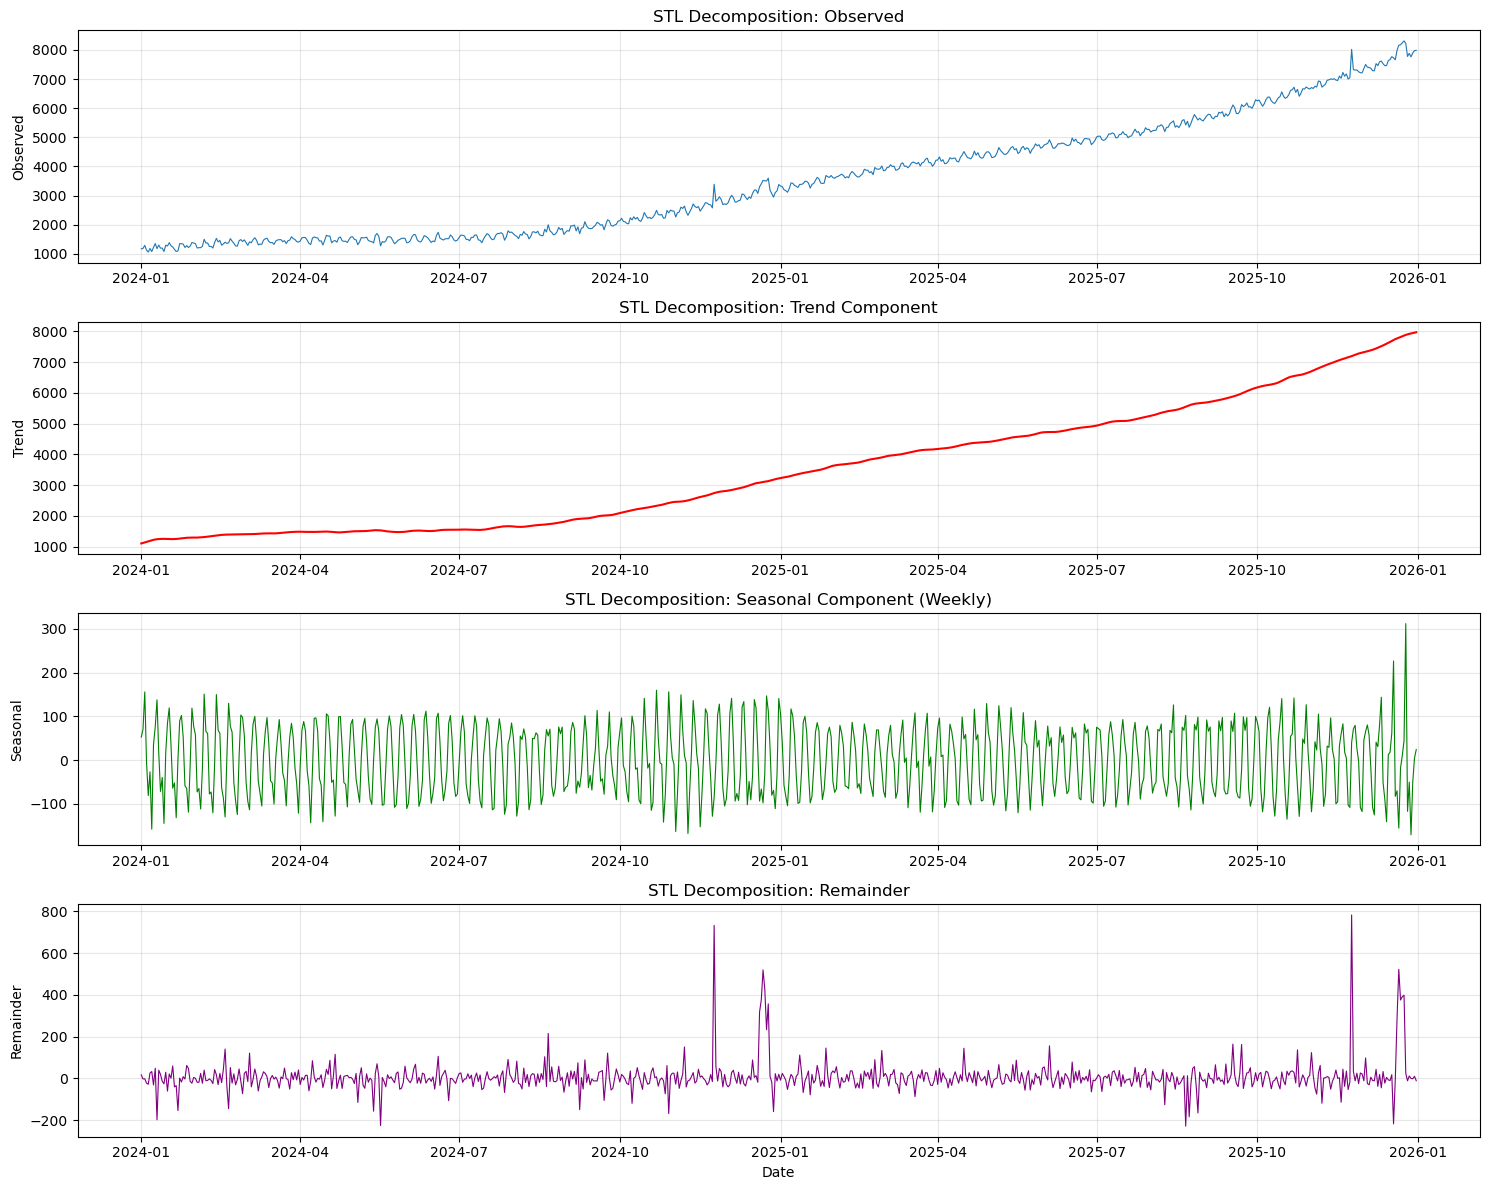

In [12]:
# --------------------------------------------------------------------
# B4: STL Decomposition
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B4: STL Decomposition")
print("-" * 70)

# 1. Apply STL decomposition
stl = STL(df_sales['Sales'], seasonal=7, robust=True)
stl_result = stl.fit()

# 2. Plot all components
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Observed
axes[0].plot(df_sales.index, stl_result.observed, linewidth=0.8)
axes[0].set_ylabel('Observed')
axes[0].set_title('STL Decomposition: Observed')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(df_sales.index, stl_result.trend, color='red', linewidth=1.5)
axes[1].set_ylabel('Trend')
axes[1].set_title('STL Decomposition: Trend Component')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(df_sales.index, stl_result.seasonal, color='green', linewidth=0.8)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('STL Decomposition: Seasonal Component (Weekly)')
axes[2].grid(True, alpha=0.3)

# Remainder
axes[3].plot(df_sales.index, stl_result.resid, color='purple', linewidth=0.8)
axes[3].set_ylabel('Remainder')
axes[3].set_xlabel('Date')
axes[3].set_title('STL Decomposition: Remainder')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('b4_stl_decomposition.png', dpi=300, bbox_inches='tight')
print("✓ STL decomposition saved as 'b4_stl_decomposition.png'")

# 3. Analyze components
print("\n📊 Component Analysis:")
print("=" * 60)
print("\nTREND:")
print(f"  • Starts at: ${stl_result.trend[~np.isnan(stl_result.trend)][0]:,.2f}")
print(f"  • Ends at: ${stl_result.trend[~np.isnan(stl_result.trend)][-1]:,.2f}")
print("  • Pattern: Strong quadratic upward trend (accelerating growth)")

print("\nSEASONAL (Weekly):")
seasonal_range = stl_result.seasonal.max() - stl_result.seasonal.min()
print(f"  • Range: ${seasonal_range:,.2f}")
print(f"  • Pattern: Clear 7-day cycle with weekend peaks")

print("\nREMAINDER:")
remainder_std = np.nanstd(stl_result.resid)
print(f"  • Std Dev: ${remainder_std:,.2f}")
print("  • Large spikes visible → special events (Black Friday, Christmas)")
print("  • Overall well-behaved random noise after removing trend/seasonal")


----------------------------------------------------------------------
B5: Remainder Analysis
----------------------------------------------------------------------
✓ Remainder diagnostics saved as 'b5_remainder_diagnostics.png'

Remainder Statistics:
Mean: $7.29 (should be ≈ $0)
Std Dev: $76.38
Skewness: 4.4578
Kurtosis: 35.2664

Normality Test (D'Agostino-Pearson):
  p-value: 0.000000
  ⚠ Reject normality (p < 0.05) - likely due to outliers

🔍 Outliers (|remainder| > 3×std = $229.13):
Number of outliers: 13

Top 10 Outlier Dates:
      Date  Remainder
2024-11-24 732.554987
2024-12-20 317.318442
2024-12-21 376.446779
2024-12-22 519.284422
2024-12-23 427.442988
2024-12-24 233.104196
2024-12-25 356.622087
2025-11-24 782.352491
2025-12-20 286.460840
2025-12-21 521.918353

📌 Special Events Identified:
  • 2024-11-24: Black Friday (high positive spike)
  • 2024-12-20: Christmas season (high positive spike)
  • 2024-12-21: Christmas season (high positive spike)
  • 2024-12-22: Christmas se

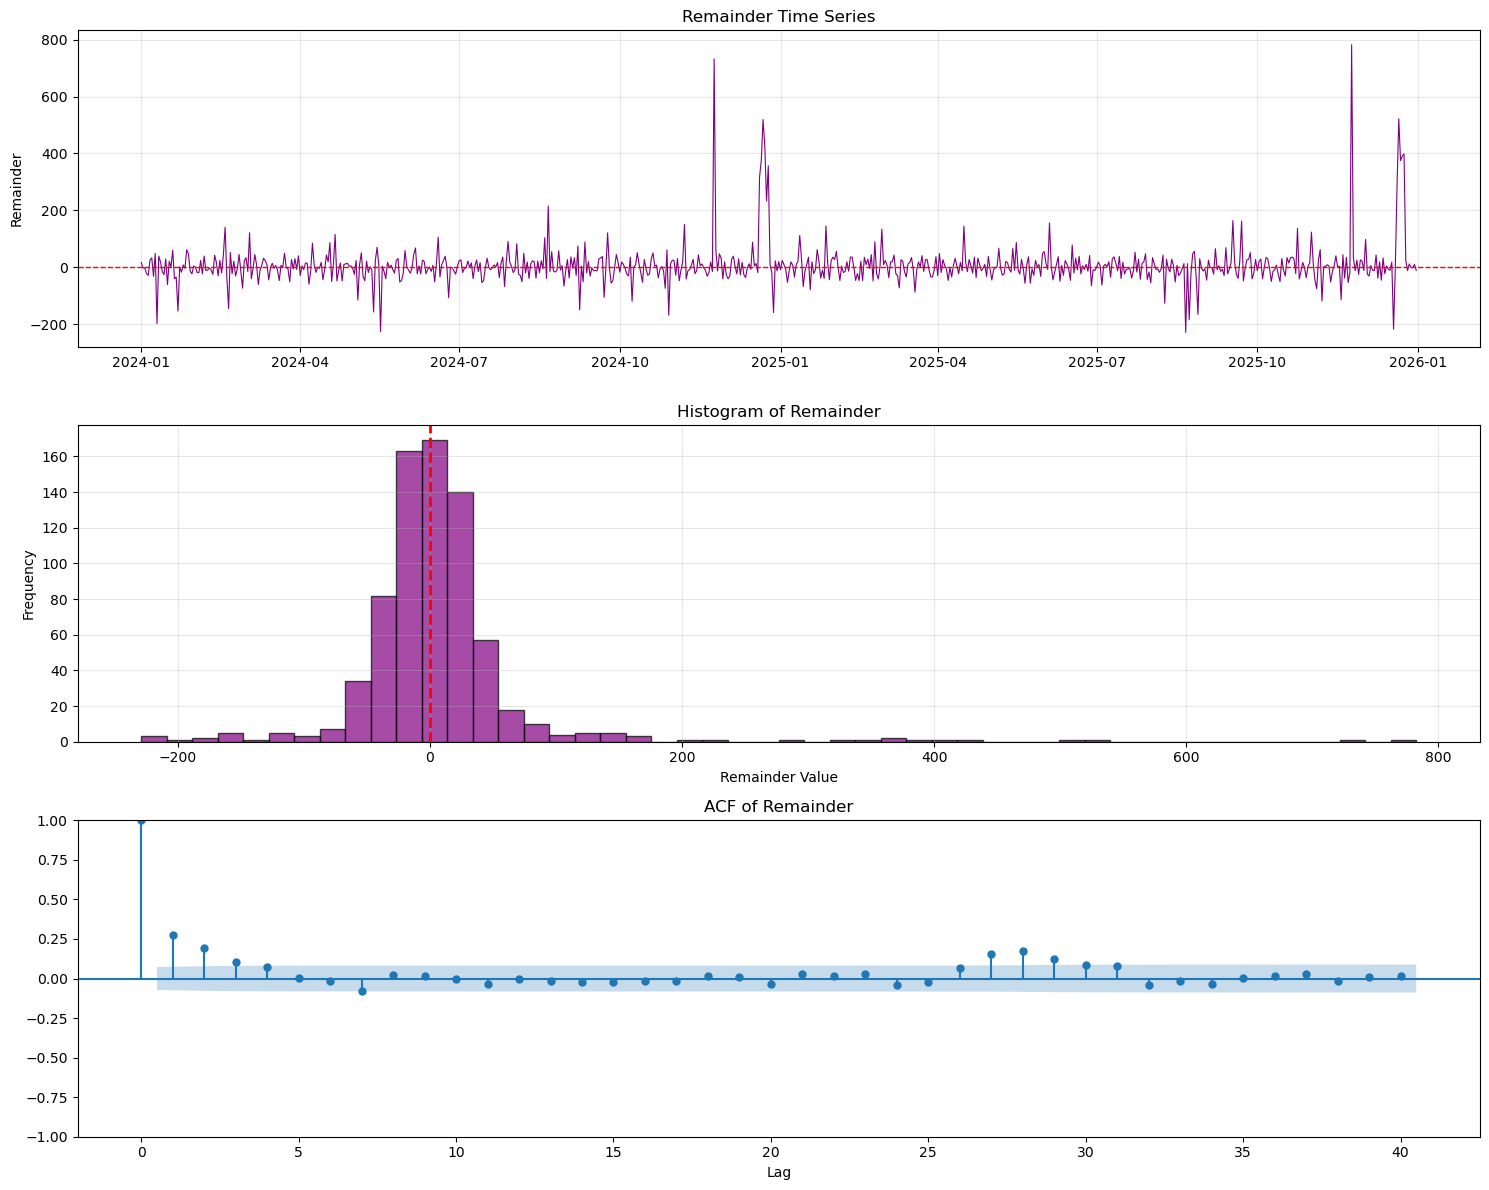

In [13]:
# B5: Remainder Diagnostics
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B5: Remainder Analysis")
print("-" * 70)

# 1. Extract remainder
remainder = stl_result.resid

# 2. Diagnostic plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Time series of remainder
axes[0].plot(df_sales.index, remainder, linewidth=0.8, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_ylabel('Remainder')
axes[0].set_title('Remainder Time Series')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(remainder.dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Remainder Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Remainder')
axes[1].grid(True, alpha=0.3)

# ACF of remainder
plot_acf(remainder.dropna(), lags=40, ax=axes[2])
axes[2].set_title('ACF of Remainder')
axes[2].set_xlabel('Lag')

plt.tight_layout()
plt.savefig('b5_remainder_diagnostics.png', dpi=300, bbox_inches='tight')
print("✓ Remainder diagnostics saved as 'b5_remainder_diagnostics.png'")

# 3. Statistical tests
remainder_clean = remainder.dropna()
remainder_mean = remainder_clean.mean()
remainder_std = remainder_clean.std()

print("\nRemainder Statistics:")
print("=" * 60)
print(f"Mean: ${remainder_mean:.2f} (should be ≈ $0)")
print(f"Std Dev: ${remainder_std:.2f}")
print(f"Skewness: {stats.skew(remainder_clean):.4f}")
print(f"Kurtosis: {stats.kurtosis(remainder_clean):.4f}")

# Normality test
_, p_value = stats.normaltest(remainder_clean)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  p-value: {p_value:.6f}")
if p_value > 0.05:
    print("  ✓ Cannot reject normality (p > 0.05)")
else:
    print("  ⚠ Reject normality (p < 0.05) - likely due to outliers")

# 4. Identify outliers
threshold = 3 * remainder_std
outliers = remainder_clean[np.abs(remainder_clean) > threshold]
outlier_dates = df_sales.index[np.abs(remainder) > threshold]

print(f"\n🔍 Outliers (|remainder| > 3×std = ${threshold:.2f}):")
print("=" * 60)
print(f"Number of outliers: {len(outliers)}")

if len(outliers) > 0:
    print("\nTop 10 Outlier Dates:")
    outlier_df = pd.DataFrame({
        'Date': outlier_dates[:10],
        'Remainder': outliers[:10].values
    })
    print(outlier_df.to_string(index=False))
    
    print("\n📌 Special Events Identified:")
    for date in outlier_dates:
        if date.month == 11 and date.day == 24:
            print(f"  • {date.date()}: Black Friday (high positive spike)")
        elif date.month == 12 and 20 <= date.day <= 25:
            print(f"  • {date.date()}: Christmas season (high positive spike)")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print("\nAll plots have been saved. Summary:")
print("  • a1_boxplots.png - EDA comparisons")
print("  • a1_correlation.png - Feature correlations")
print("  • a2_lpm_predictions.png - Linear Probability Model")
print("  • a3_logit_predictions.png - Logistic Regression")
print("  • b1_timeseries.png - Full time series")
print("  • b1_seasonal.png - Seasonal patterns")
print("  • b2_stationarity.png - Rolling statistics")
print("  • b3_acf.png - Autocorrelation function")
print("  • b4_stl_decomposition.png - STL components")
print("  • b5_remainder_diagnostics.png - Remainder analysis")